<a href="https://colab.research.google.com/github/isaacfinberg/Novozymes-Enzyme-Stability-Prediction/blob/richard-nonpytorch-develop/protbert_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive; drive.mount('/content/drive')   # OK to enable, if your kaggle.json is stored in Google Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !pip -q install --upgrade --force-reinstall --no-deps kaggle > log  
# !mkdir -p ~/.kaggle                                          
# !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json >log 
# !cp kaggle.json ~/.kaggle/kaggle.json > log              
# !chmod 600 ~/.kaggle/kaggle.json                            
# !kaggle config set -n competition -v novozymes-enzyme-stability-prediction   
# !kaggle competitions download -c novozymes-enzyme-stability-prediction         
# !unzip -o *.zip >> log                           
# # !kaggle competitions leaderboard --show                

cp: cannot stat 'kaggle.json': No such file or directory
- competition is now set to: novozymes-enzyme-stability-prediction
novozymes-enzyme-stability-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
import pandas as pd
import numpy as np

# df = pd.read_csv('train.csv', low_memory=False); df

In [3]:
# df_test = pd.read_csv('test.csv', low_memory=False)
# df_test.head()

# Read/Format Embeddings

In [4]:
emb_train = pd.read_csv('/content/drive/Shareddrives/JHU Data Science Masters/Deep Learning/Project/embedding_csv.csv').set_index('seq_id')
emb_test = pd.read_csv('/content/drive/Shareddrives/JHU Data Science Masters/Deep Learning/Project/test_embeddings.csv', engine='python', error_bad_lines=False).set_index('seq_id')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
emb_train['bert_embedding'] = emb_train['bert_embedding'].apply(lambda x: x.strip('][').split(', '))
emb_test['bert_embedding'] = emb_test['bert_embedding'].apply(lambda x: x.strip('][').split(', '))
emb_train = emb_train[['bert_embedding', 'tm']]
emb_test = emb_test[['bert_embedding']]

In [13]:
for idx, row in emb_train.iterrows():
    emb_train.at[idx, 'bert_embedding'] = list(map(float, row['bert_embedding']))

In [14]:
for idx, row in emb_test.iterrows():
    emb_test.at[idx, 'bert_embedding'] = list(map(float, row['bert_embedding']))

In [ ]:
emb_train['bert_embedding'][0]

# Tree based regressor

In [16]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_extraction import text
from sklearn.random_projection import GaussianRandomProjection
from scipy import stats
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, Flatten, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

SEED = 0

In [36]:
train_X, test_X, train_y, test_y = train_test_split(np.array(emb_train['bert_embedding'].tolist()), np.array(emb_train['tm'].tolist()), test_size=1000, random_state=SEED, shuffle=True)

In [ ]:
regressor = GradientBoostingRegressor(loss='squared_error', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', 
                                      min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, 
                                      init=None, random_state=None, max_features=None, alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False, 
                                      validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)
regressor = Hist
regressor.fit(train_X, train_y)

In [ ]:
!pip install lightgbm
import lightgbm as lgb

In [48]:
import tensorflow.keras as keras
from keras.layers import Dropout
from keras.layers import Normalization
from keras.layers import BatchNormalization

tf.random.set_seed(0)   # always seed your experiments
# Init = keras.initializers.RandomNormal(seed=0)
Init= keras.initializers.LecunNormal(seed=0)
import numpy as np
epochs=100
cosine_annealing_lr = tf.keras.optimizers.schedules.CosineDecay(
    0.001, 8*epochs)


m = keras.models.Sequential([
    Flatten(input_shape=[train_X.shape[1]]),
    # Dropout(0.5, seed=0),
    Dense(2048, activation="relu", kernel_initializer=Init, name='Dense1'),
    # Dropout(0.2, seed=0),
    BatchNormalization(),
    Dense(2048, activation="relu", kernel_initializer=Init),
    # Dropout(0.2, seed=0),
    BatchNormalization(),
    Dense(2048, activation="relu", kernel_initializer=Init),
    # Dropout(0.2, seed=0),
    BatchNormalization(),
    Dense(2048, activation="relu", kernel_initializer=Init),
    # Dropout(0.2, seed=0),
    BatchNormalization(),
    Dense(2048, activation="relu", kernel_initializer=Init),
    # Dropout(0.2, seed=0),
    BatchNormalization(),
    Dense(1, kernel_initializer=Init)])
m.summary()
m.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(
                # learning_rate = cosine_annealing_lr
                learning_rate = 0.001
                ), metrics=['mse'])
hist = m.fit(train_X,
             train_y, 
             batch_size=2096, 
             epochs=100, 
             validation_split=0.2, 
            #  callbacks=[wandb.keras.WandbCallback()]
             )

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 1024)              0         
                                                                 
 Dense1 (Dense)              (None, 2048)              2099200   
                                                                 
 batch_normalization_17 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense_17 (Dense)            (None, 2048)              4196352   
                                                                 
 batch_normalization_18 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense_18 (Dense)            (None, 2048)             

In [38]:
regressor2 = XGBRegressor()
regressor2.fit(train_X, train_y)

[06:34:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [46]:
# preds = regressor2.predict(test_X)
preds = m.predict(test_X)
spearman = stats.spearmanr(test_y, preds)
print(spearman)

32/32 [==============================] - 0s 2ms/step
SpearmanrResult(correlation=0.03038746665891997, pvalue=0.33707741457558815)


(array([  1.,  29.,  60., 335., 395.,  87.,  49.,  39.,   4.,   1.]),
 array([  0. ,  11.6,  23.2,  34.8,  46.4,  58. ,  69.6,  81.2,  92.8,
        104.4, 116. ]),
 <a list of 10 Patch objects>)

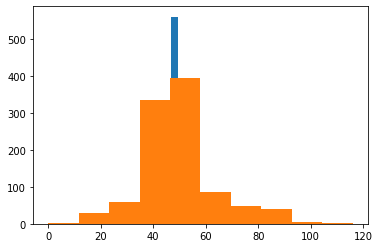

In [40]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.hist(preds)
plt.hist(test_y)

In [ ]:
# test_final = trans_seq.transform(df_test['protein_sequence'])
# test_final = projector.transform(test_final)
# # test_final = scaler.transform(test_final)

In [ ]:
# test_final = trans_seq.transform(df_test['protein_sequence'])
# test_final = projector.transform(test_final)
# test_final = scaler.transform(test_final)
# predictions = model.predict(test_final)

# ToCSV = lambda df_tmp, fname: df_tmp.to_csv(f'{fname}.csv', index_label='seq_id')
# pY = pd.DataFrame(predictions, index=range(31390,len(predictions)+31390), columns=['tm'])
# ToCSV(pY, './MySubmission')

76/76 [==============================] - 0s 2ms/step


In [50]:
predictions = m.predict(np.array(emb_test['bert_embedding'].tolist()))
pY = pd.DataFrame(predictions, index=range(31390,len(predictions)+31390), columns=['tm'])
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals
ToCSV(pY, './MySubmission')

76/76 [==============================] - 0s 2ms/step
